### importing necessary libraries 

In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as fn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# loading the datasets

### loading the MNIST dataset

In [103]:
# Preprocessing MNIST dataset
transform_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Loading the MNIST dataset
train_mnist = datasets.MNIST(root='./mnist', train=True, transform=transform_mnist, download=True)
test_mnist = datasets.MNIST(root='./mnist', train=False, transform=transform_mnist, download=True)

# Defining input channels for MNIST
input_channel_mnist = 1

# DataLoader for MNIST
train_loader_mnist = DataLoader(train_mnist, batch_size=64, shuffle=True)
test_loader_mnist = DataLoader(test_mnist, batch_size=64, shuffle=False)

### loading the CIFAR-10 dataset

In [104]:
# Preprocessing CIFAR-10 dataset
transform_cifar10 = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Loading CIFAR-10 dataset
train_cifar10 = datasets.CIFAR10(root='./cifar', train=True, transform=transform_cifar10, download=True)
test_cifar10 = datasets.CIFAR10(root='./cifar', train=False, transform=transform_cifar10, download=True)

# Defining input channels for CIFAR-10
input_channels_cifar10 = 3

# DataLoader for CIFAR-10
train_loader_cifar10 = DataLoader(train_cifar10, batch_size=64, shuffle=True)
test_loader_cifar10 = DataLoader(test_cifar10, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# Building and defining necessary classes and functions 

### Defining the ArcFace Loss Class

In [105]:
class ArcFaceLoss(nn.Module):
    def __init__(self, feature_dim, num_classes, margin, scale):
        super(ArcFaceLoss, self).__init__()
        self.margin = margin                                                                    # Angular margin
        self.scale = scale                                                                      # Scaling factor

        # Initialize the weights for the class centers
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, feature_dim))
        nn.init.xavier_uniform_(self.weight)                                                    # using Xavier uniform initialization to give the class centers a balanced starting point, which helps stabilize training and improve model performance

    def forward(self, features, labels):
        
        # using L2 normalization to ensure similarity calculation relies purely on the vector angles and not their magnitude 
        normalized_features = fn.normalize(features)
        normalized_weight = fn.normalize(self.weight)
        
	    # Calculating cosine similarity between input features and class centers
        cosine_similarity = torch.matmul(normalized_features, normalized_weight.T)
        target_cosine = cosine_similarity[range(len(labels)), labels]
        
	    # Adding angular margin to the target class and adjusting its cosine similarity hence enforcing the feature vector to be closer to its correct class center          
        target_cosine_with_margin = torch.cos(torch.acos(target_cosine) + self.margin)
        cosine_similarity[range(len(labels)), labels] = target_cosine_with_margin
        
        # Scaling logits and computing the loss on the arcface adjusted dataset
        logits = self.scale * cosine_similarity
        aj = fn.cross_entropy(logits, labels)
        return aj


### Defining the CNN Model

In [106]:
# using simple cnn as it aligns with our interest of embedded learning using arc face
class SimpleCNN(nn.Module):
    def __init__(self, input_channels, feature_dim=512):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),       # using padding as it helps us retain original dimensions which in-turn helps us in better edge retention
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d((8, 8))
        )

        self.fc = nn.Linear(64 * 8 * 8, feature_dim)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        features = self.fc(x)
        return features

### defining a function to look at our predictions 

In [107]:
# CIFAR-10 class names
cifar_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                     'dog', 'frog', 'horse', 'ship', 'truck']


# Visualization function to show sample predictions in a grid with true labels
def visualize_predictions_grid(model, loader, arcface_loss, num_images, class_names=None):
    images_shown = 0

    # Calculating grid size based on the number of images
    grid_size = int(num_images ** 0.5)
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    axs = axs.flatten()                                                                                             # Flattening for easy indexing of each subplot

    with torch.no_grad():
        # Taking a batch of images from the specified dataloader
        images, labels = next(iter(loader))
        features = model(images)
        logits = torch.matmul(fn.normalize(features), fn.normalize(arcface_loss.weight).T) * arcface_loss.scale
        predicted = torch.argmax(logits, dim=1)

        for i in range(num_images):
            # Normalize the images for display
            img = images[i].cpu().numpy()
            if img.shape[0] == 3:
                img = img.transpose(1, 2, 0)                                                                         # Converting from rgb to HCW( height channel width) format for ease of display
                img = (img + 1) / 2                                                                                  # Normalizing to [0, 1] for display
            else:  # Grayscale (MNIST)
                img = img.squeeze()                                                                                  # Removing channel dimension for grayscale display
                img = (img + 1) / 2                                                                                  

            # Clipping image to [0, 1] range for display
            img = np.clip(img, 0, 1)
            axs[i].imshow(img, cmap='gray' if img.ndim == 2 else None)                                               # Setting cmap for grayscale

            # Getting the predicted and true class names
            if class_names:
                pred_class = class_names[predicted[i].item()]
                true_class = class_names[labels[i].item()]
            else:
                pred_class = predicted[i].item()
                true_class = labels[i].item()

            # Setting title with predicted and true labels
            axs[i].set_title(f"Pred: {pred_class}\nTrue: {true_class}", fontsize=10)
            axs[i].axis('off') 

        plt.tight_layout(pad=2.0)                                                                                     # Adding a padding to prevent overlap of titles
        plt.show()

# Training and Evaluation Loop for MNIST Dataset

In [108]:
# Initializing the model, loss function, and optimizer for MNIST
model_mnist = SimpleCNN(input_channels=input_channel_mnist)
arcface_mnist = ArcFaceLoss(feature_dim=512, num_classes=10,margin=0.3,scale=40)
optimizer = torch.optim.Adam(model_mnist.parameters(), lr=0.001)

Epoch [1/5], Loss: 1.4545, Accuracy: 95.09%


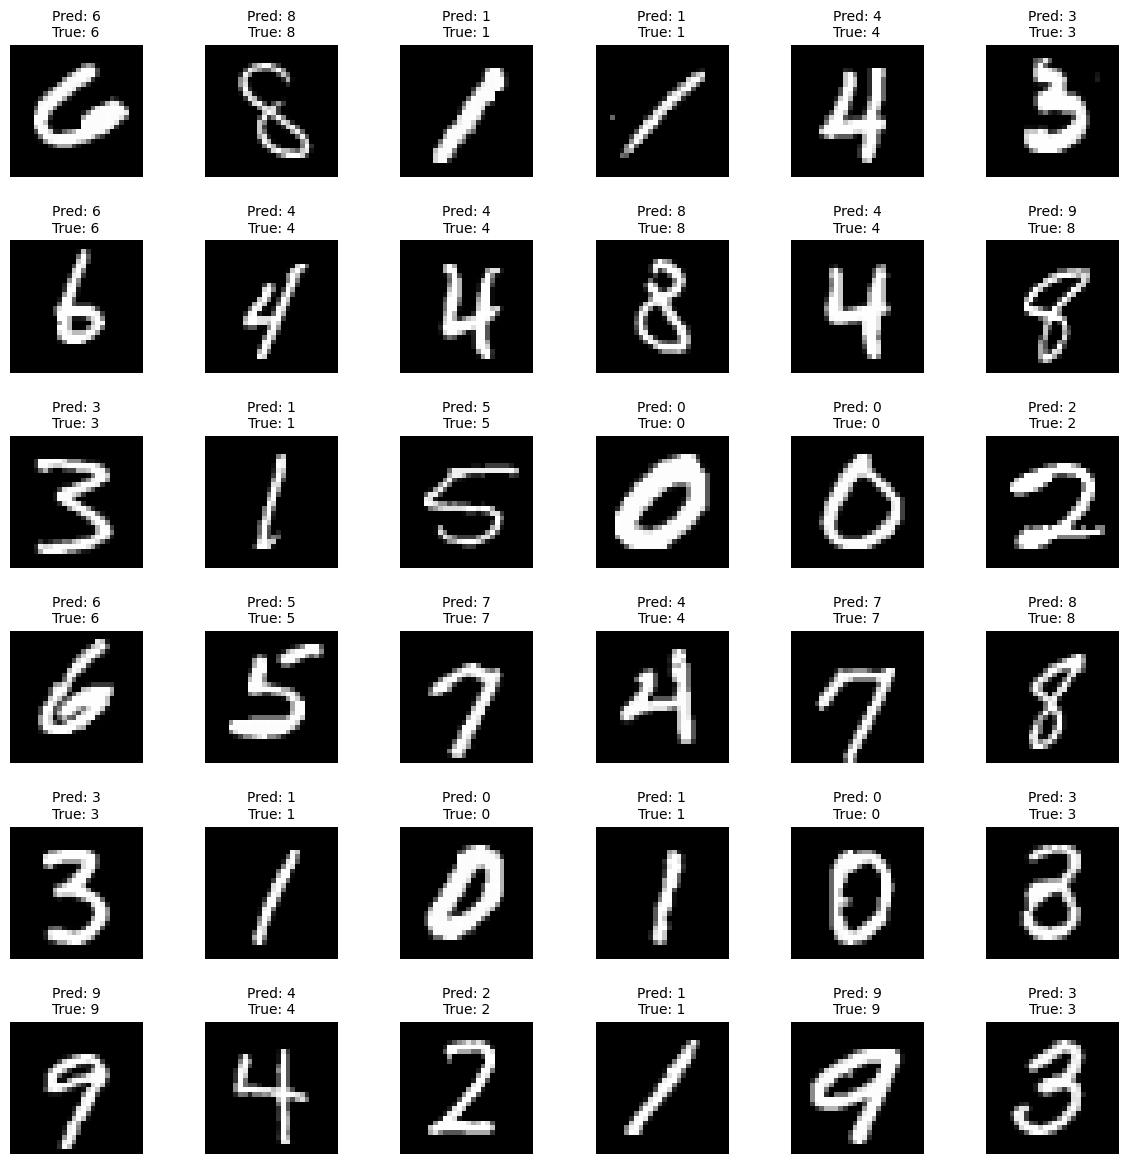

Epoch [2/5], Loss: 0.4446, Accuracy: 98.61%


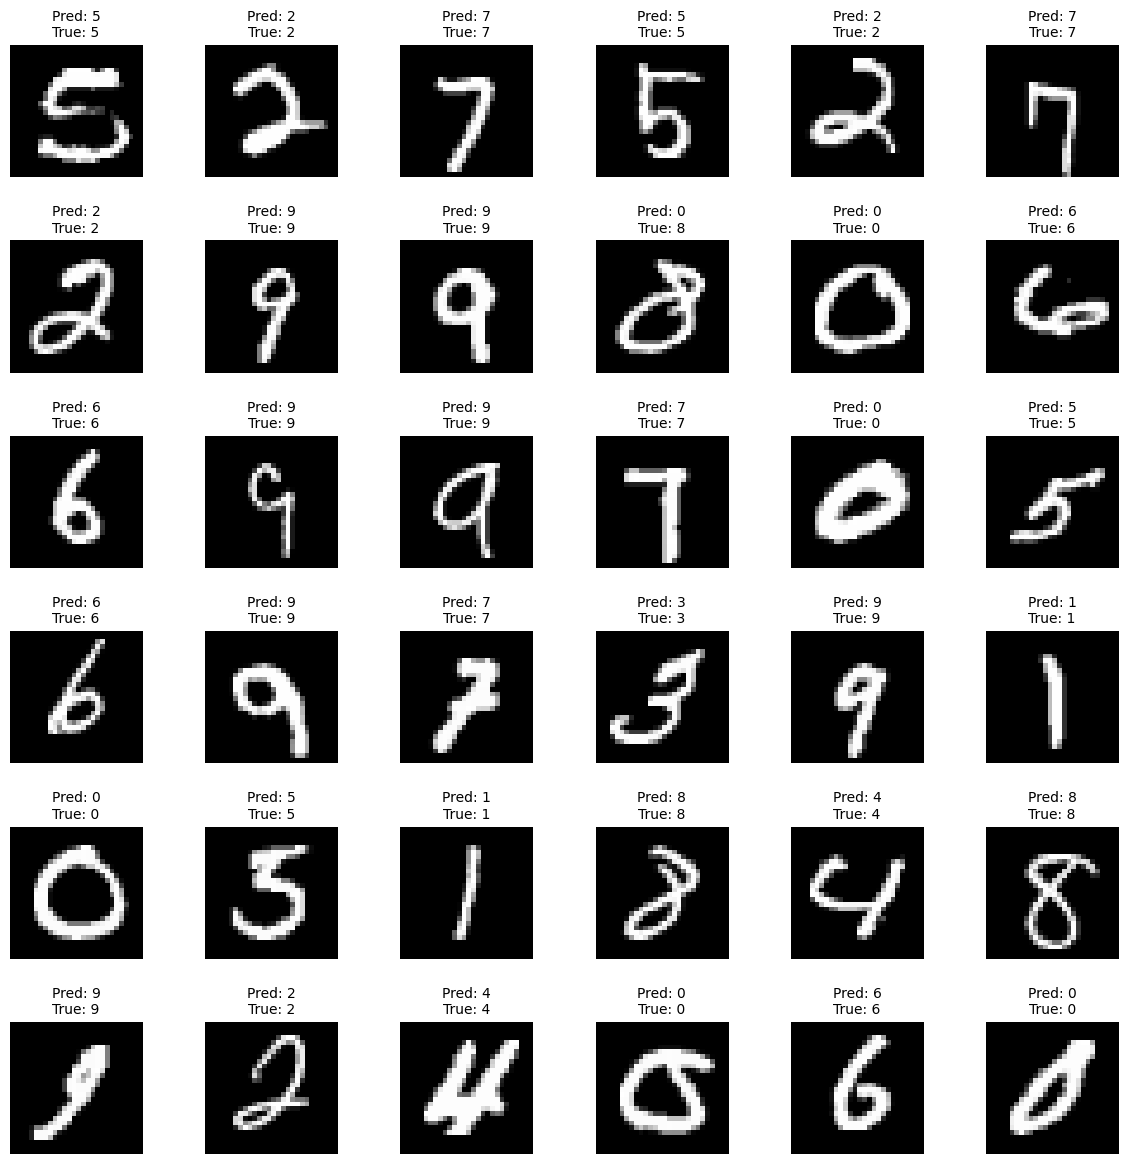

Epoch [3/5], Loss: 0.3602, Accuracy: 98.90%


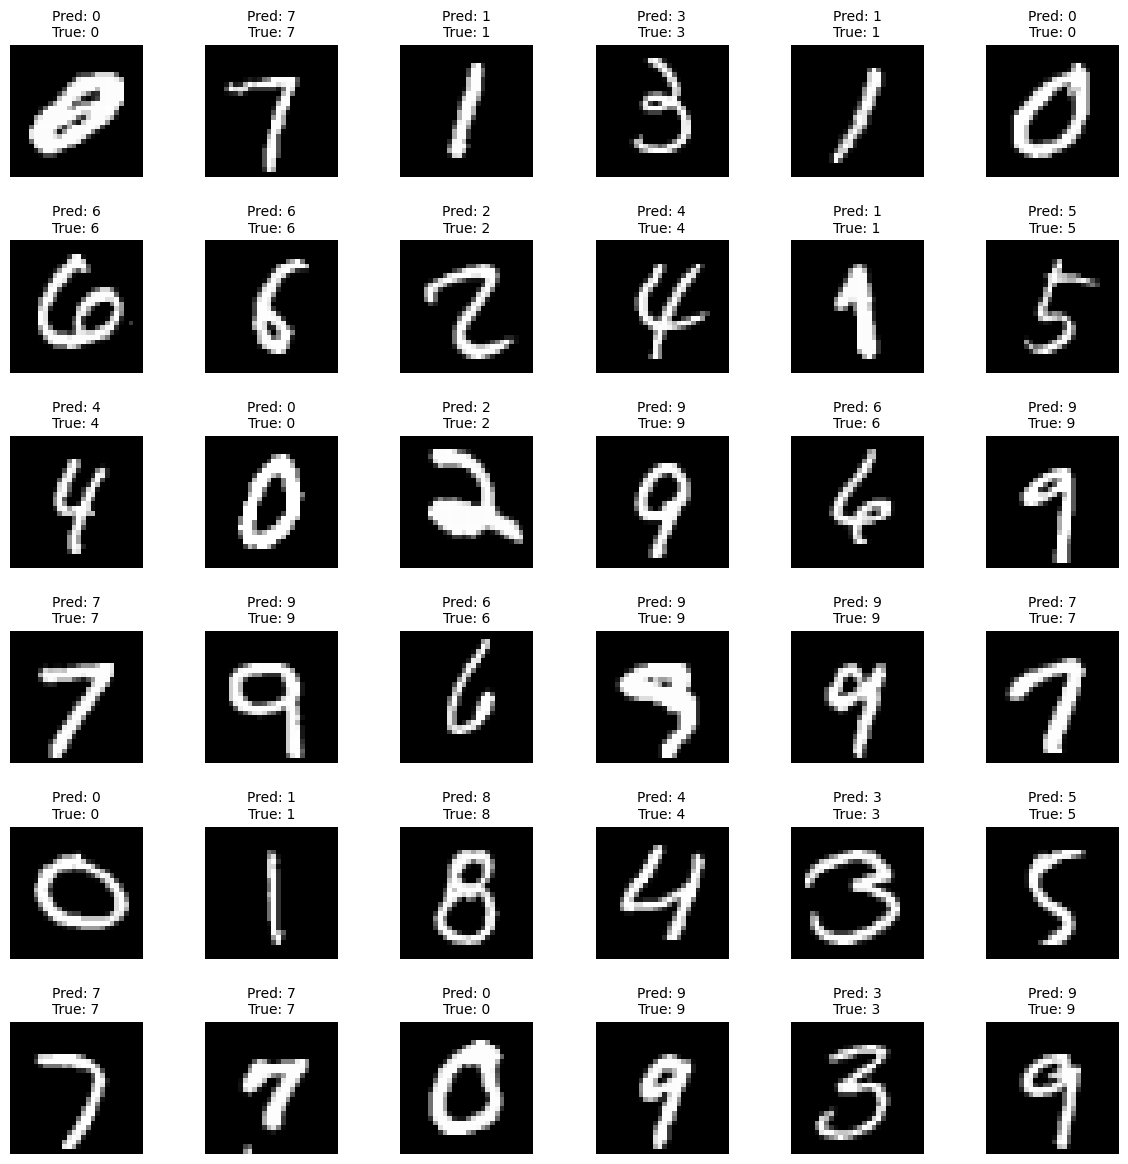

Epoch [4/5], Loss: 0.3023, Accuracy: 99.08%


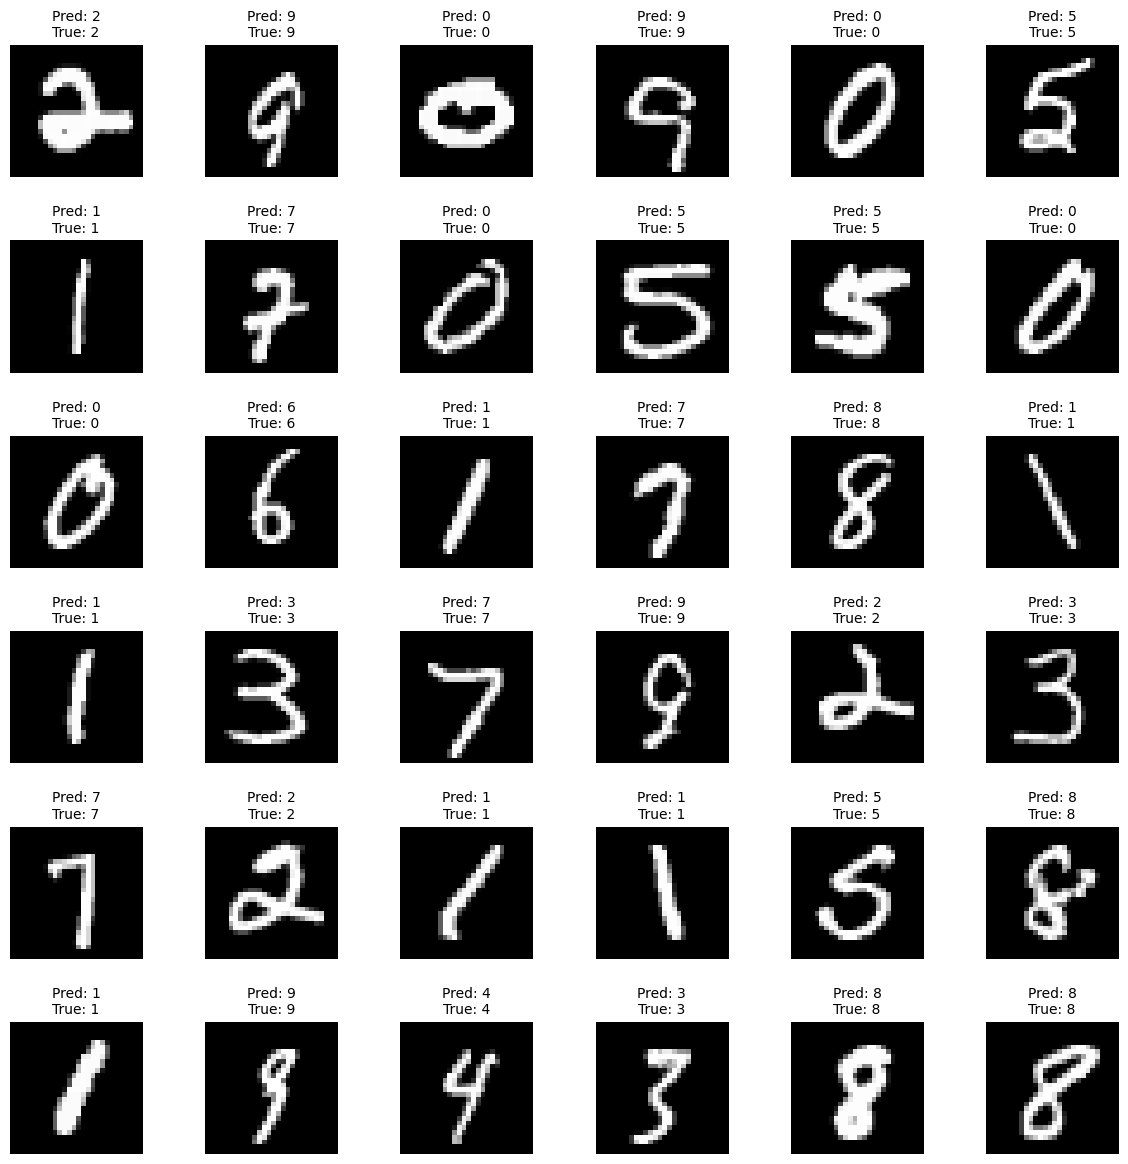

Epoch [5/5], Loss: 0.2663, Accuracy: 99.22%


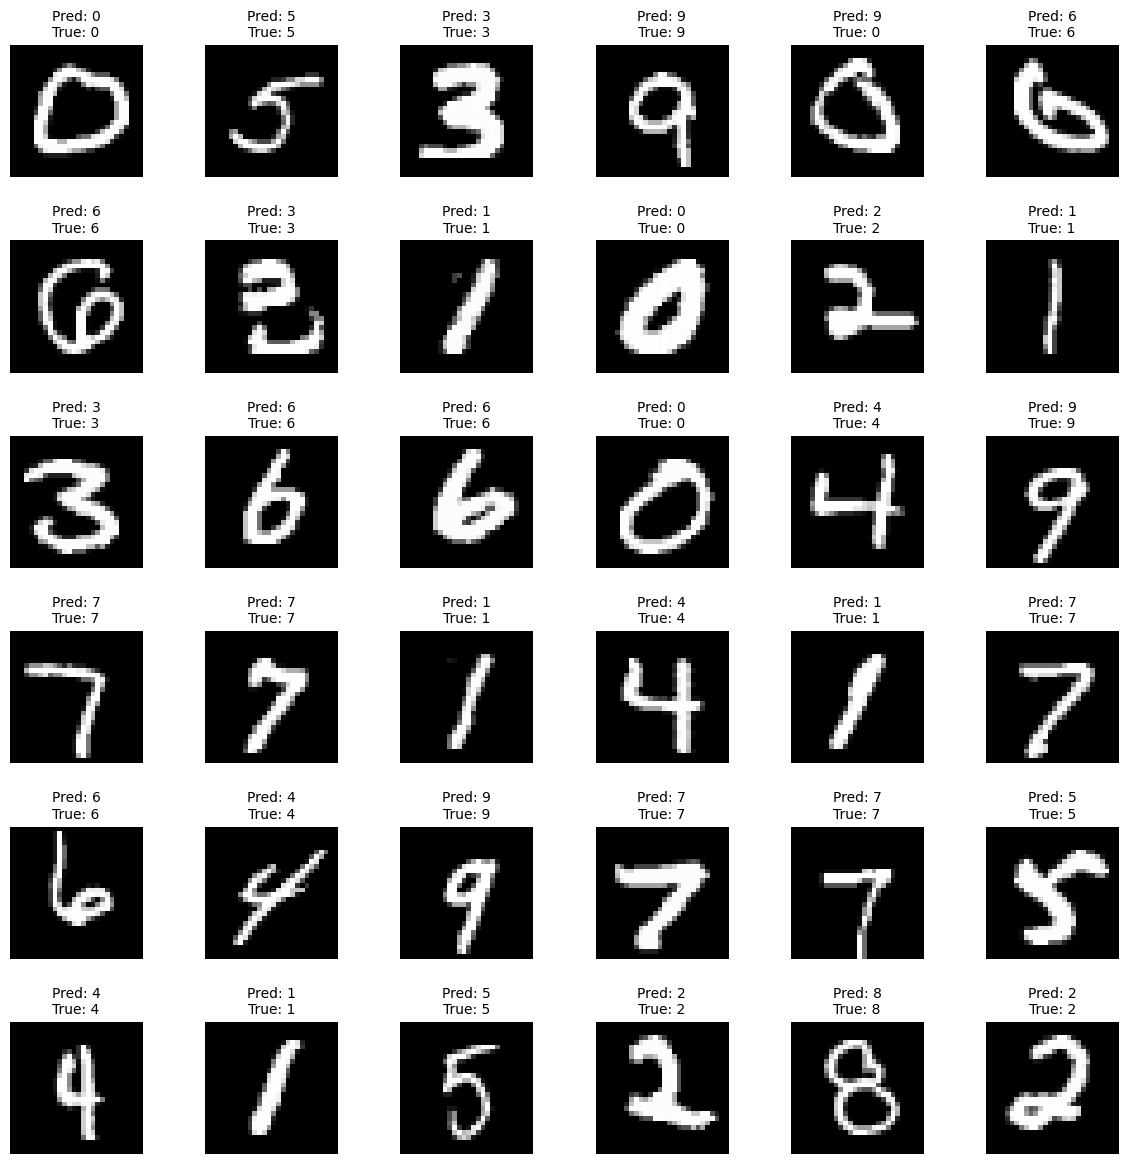

In [109]:
# Training Loop
num_epochs = 5
model_mnist.train()
for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader_mnist:
        optimizer.zero_grad()

        # Forward pass
        features = model_mnist(images)
        loss = arcface_mnist(features, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy for the batch
        with torch.no_grad():
            logits = torch.matmul(fn.normalize(features), fn.normalize(arcface_mnist.weight).T) * arcface_mnist.scale
            predicted = torch.argmax(logits, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate accuracy for the epoch
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader_mnist):.4f}, Accuracy: {accuracy:.2f}%")
    visualize_predictions_grid(model_mnist, train_loader_mnist, arcface_mnist, num_images=36)

Test Accuracy on MNIST: 98.68%


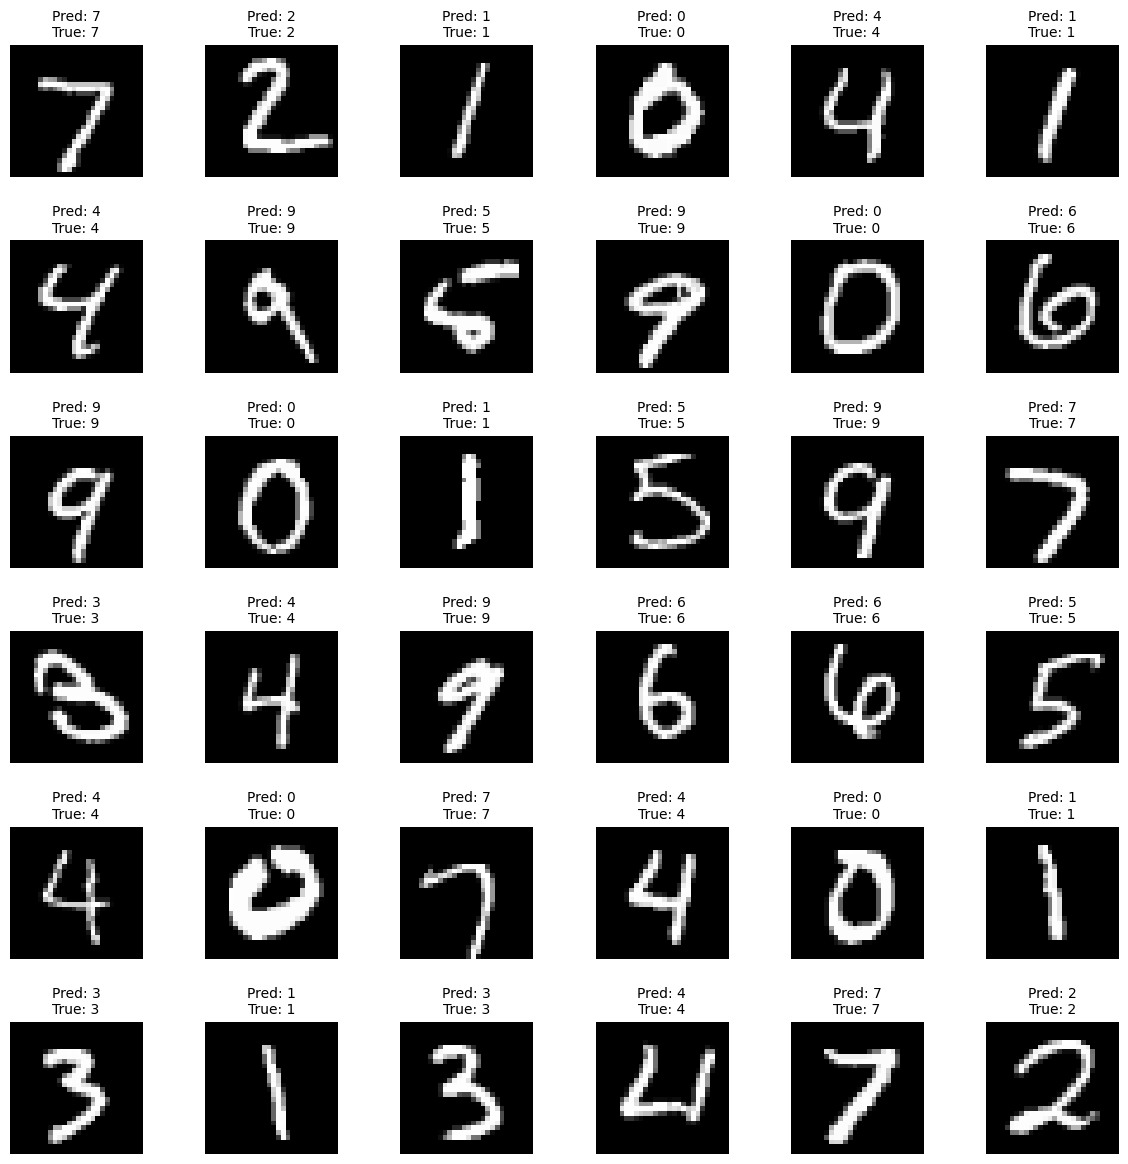

In [110]:
# Evaluation Loop
model_mnist.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader_mnist:
        features = model_mnist(images)
        logits = torch.matmul(fn.normalize(features),
                              fn.normalize(arcface_mnist.weight).T) * arcface_mnist.scale
        predicted = torch.argmax(logits, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy on MNIST: {accuracy:.2f}%")
visualize_predictions_grid(model_mnist, test_loader_mnist, arcface_mnist,num_images=36)

# Training and Evaluation Loop for CIFAR-10 Dataset

In [115]:
# Initializing the model, loss function, and optimizer
model_cifar = SimpleCNN(input_channels=input_channels_cifar10)
arcface_cifar = ArcFaceLoss(feature_dim=512, num_classes=10,margin=0.1,scale=10)
optimizer = torch.optim.Adam(model_cifar.parameters(), lr=0.001)

Epoch [1/10], Loss: 1.5929, Accuracy: 56.75%


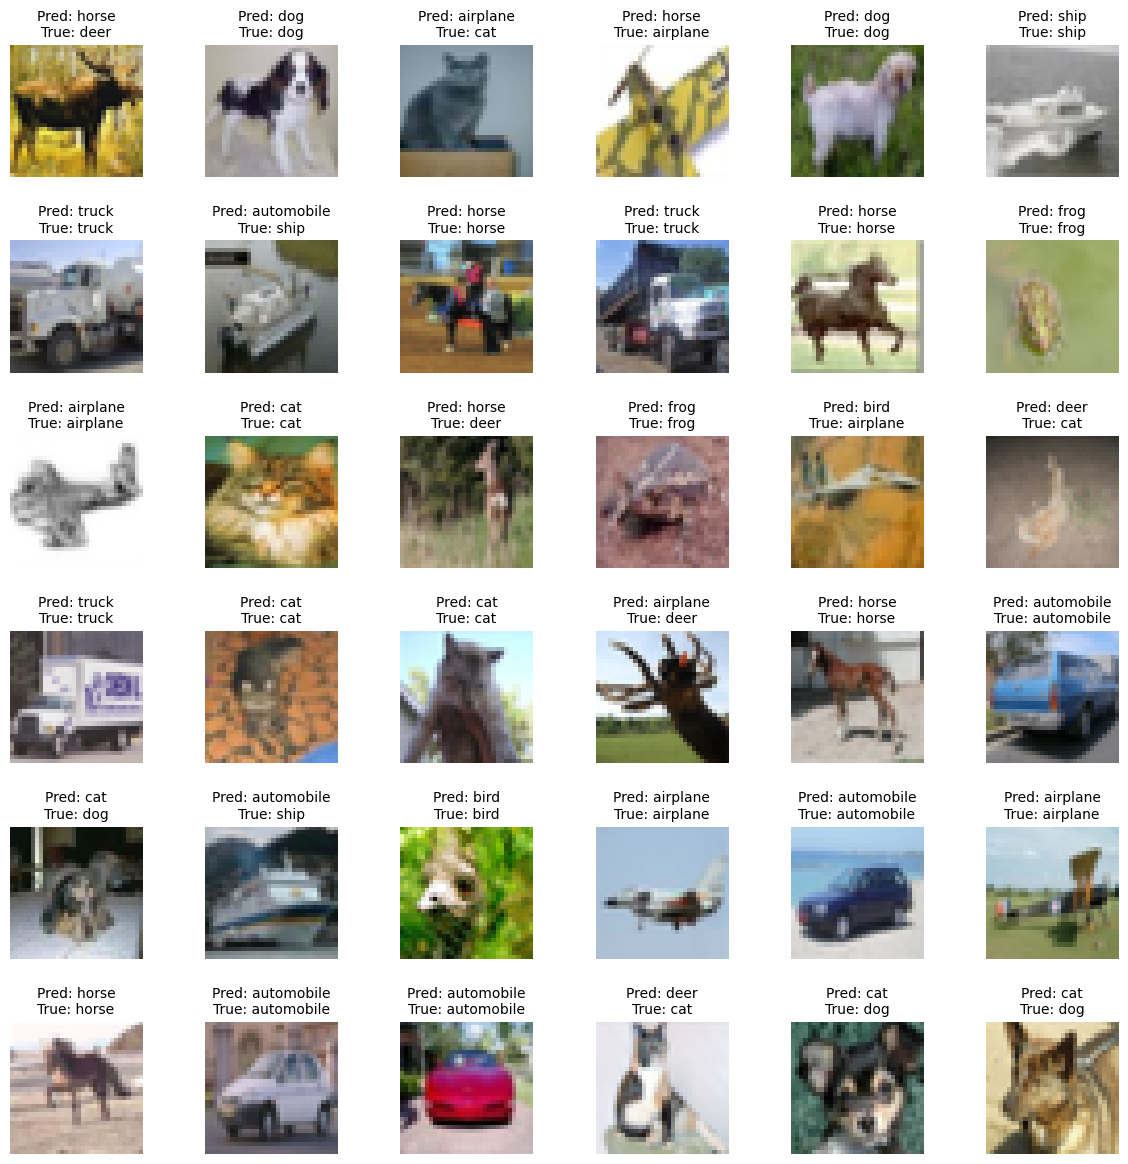

Epoch [2/10], Loss: 1.1521, Accuracy: 61.59%


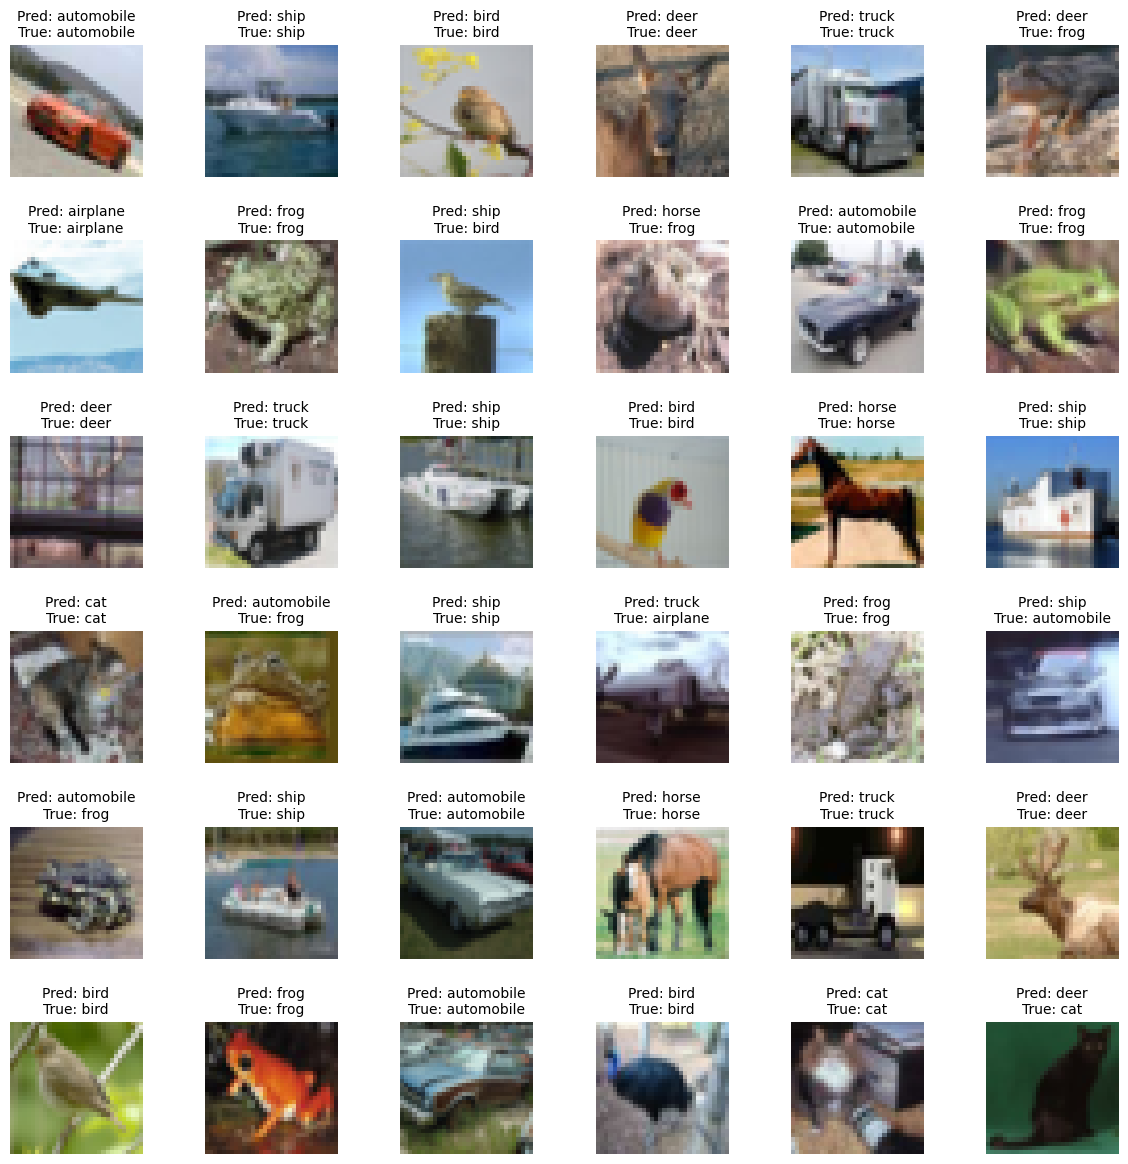

Epoch [3/10], Loss: 0.9963, Accuracy: 64.85%


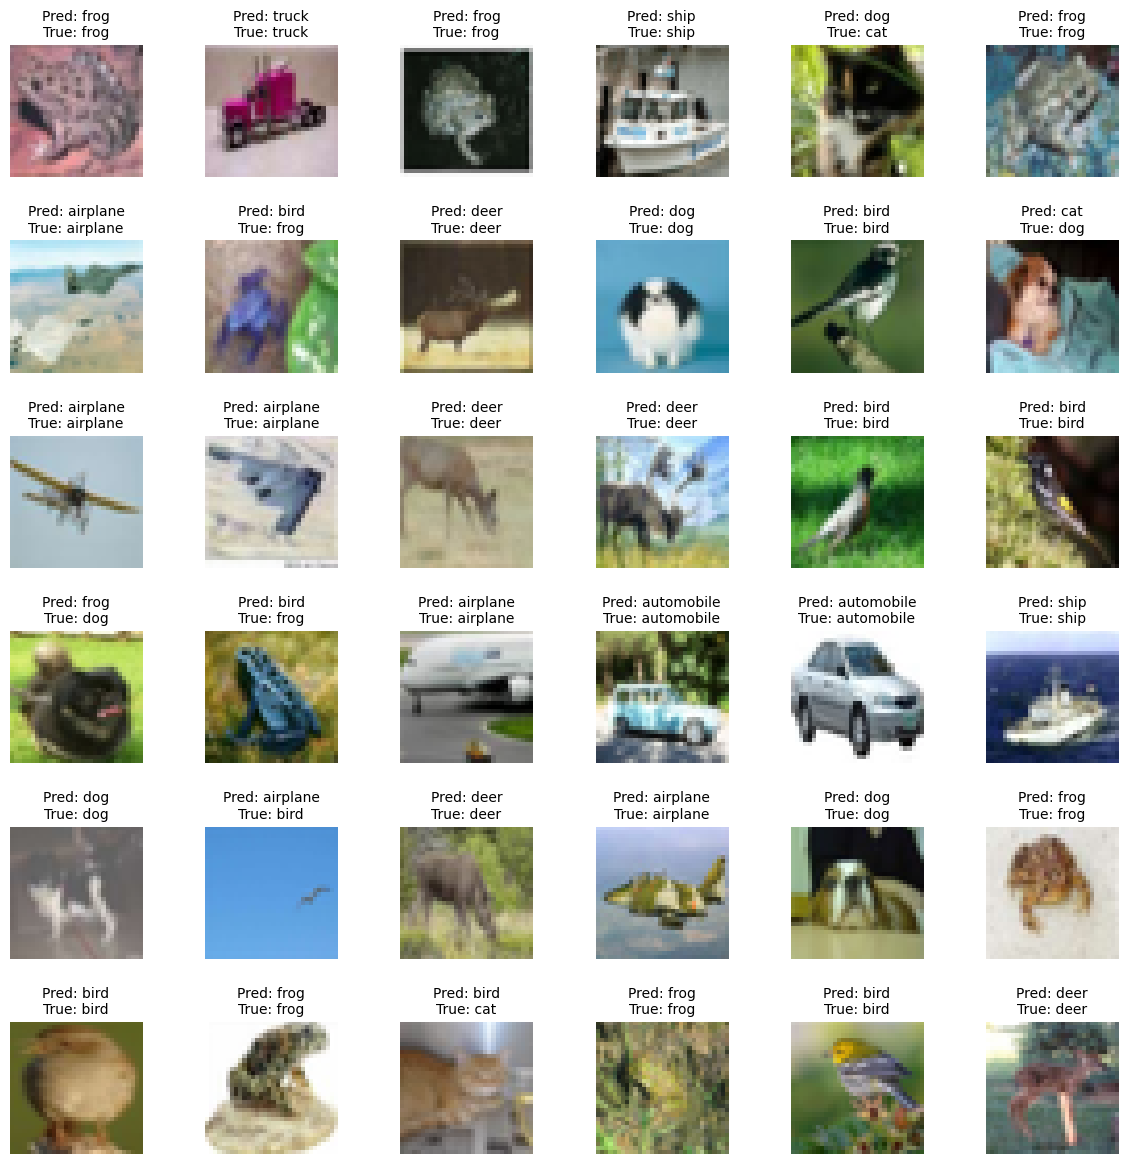

Epoch [4/10], Loss: 0.9046, Accuracy: 67.23%


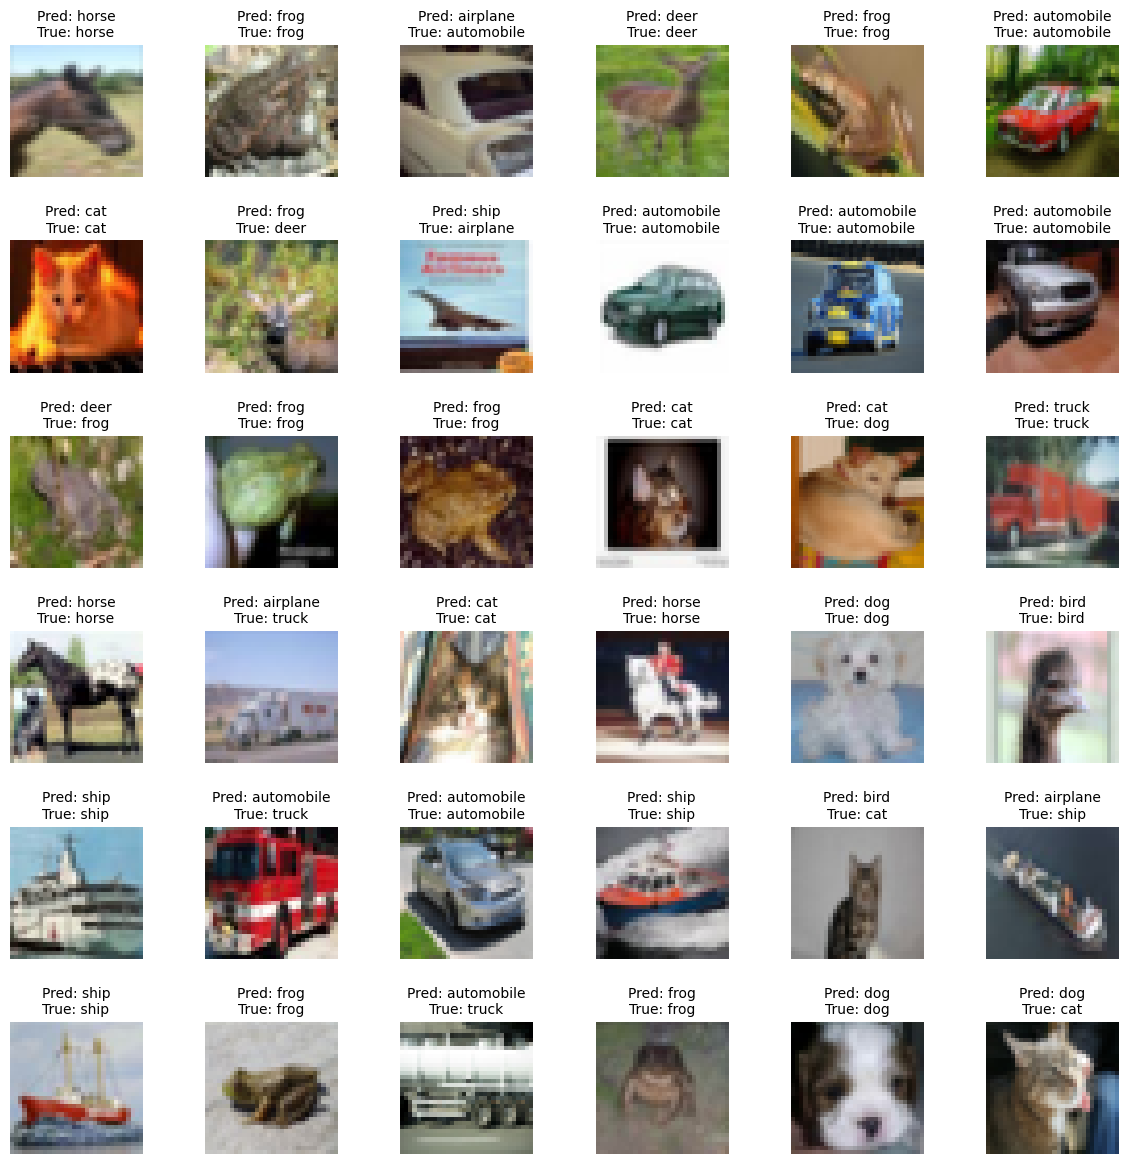

Epoch [5/10], Loss: 0.8352, Accuracy: 69.08%


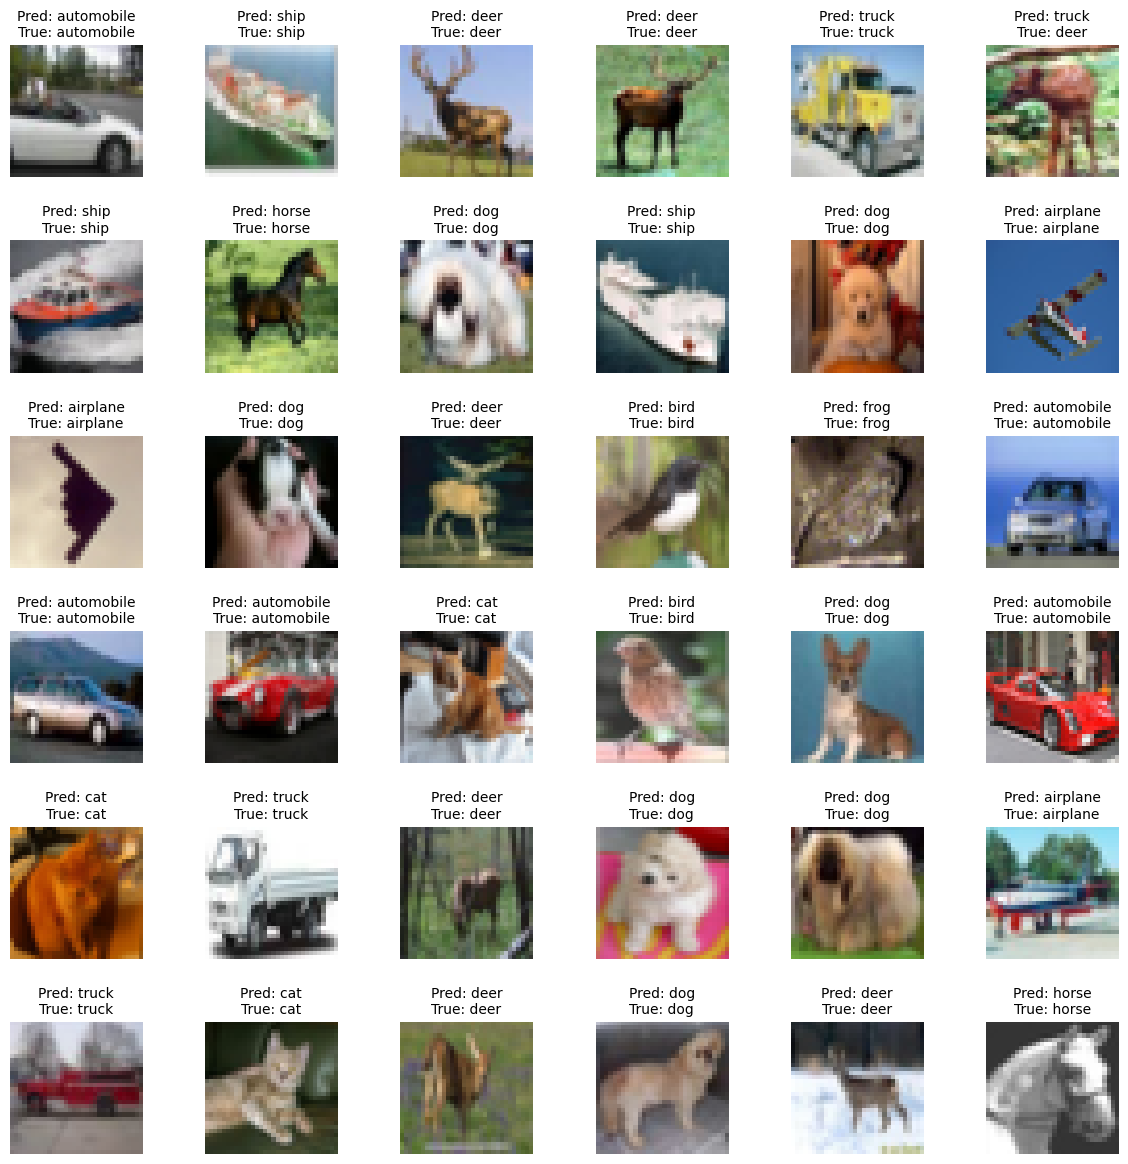

Epoch [6/10], Loss: 0.7813, Accuracy: 70.61%


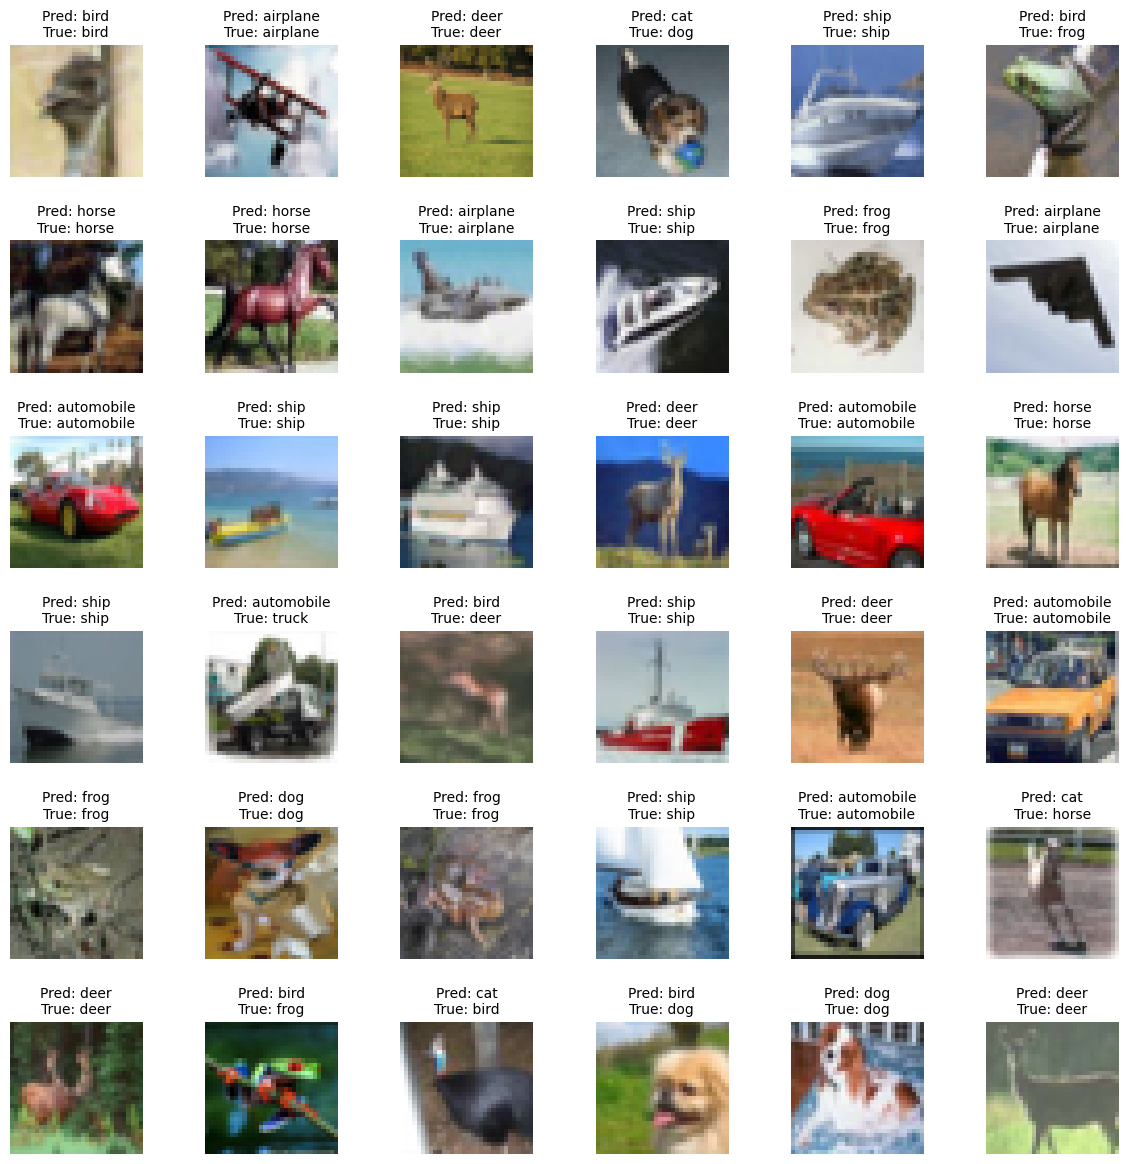

Epoch [7/10], Loss: 0.7397, Accuracy: 71.87%


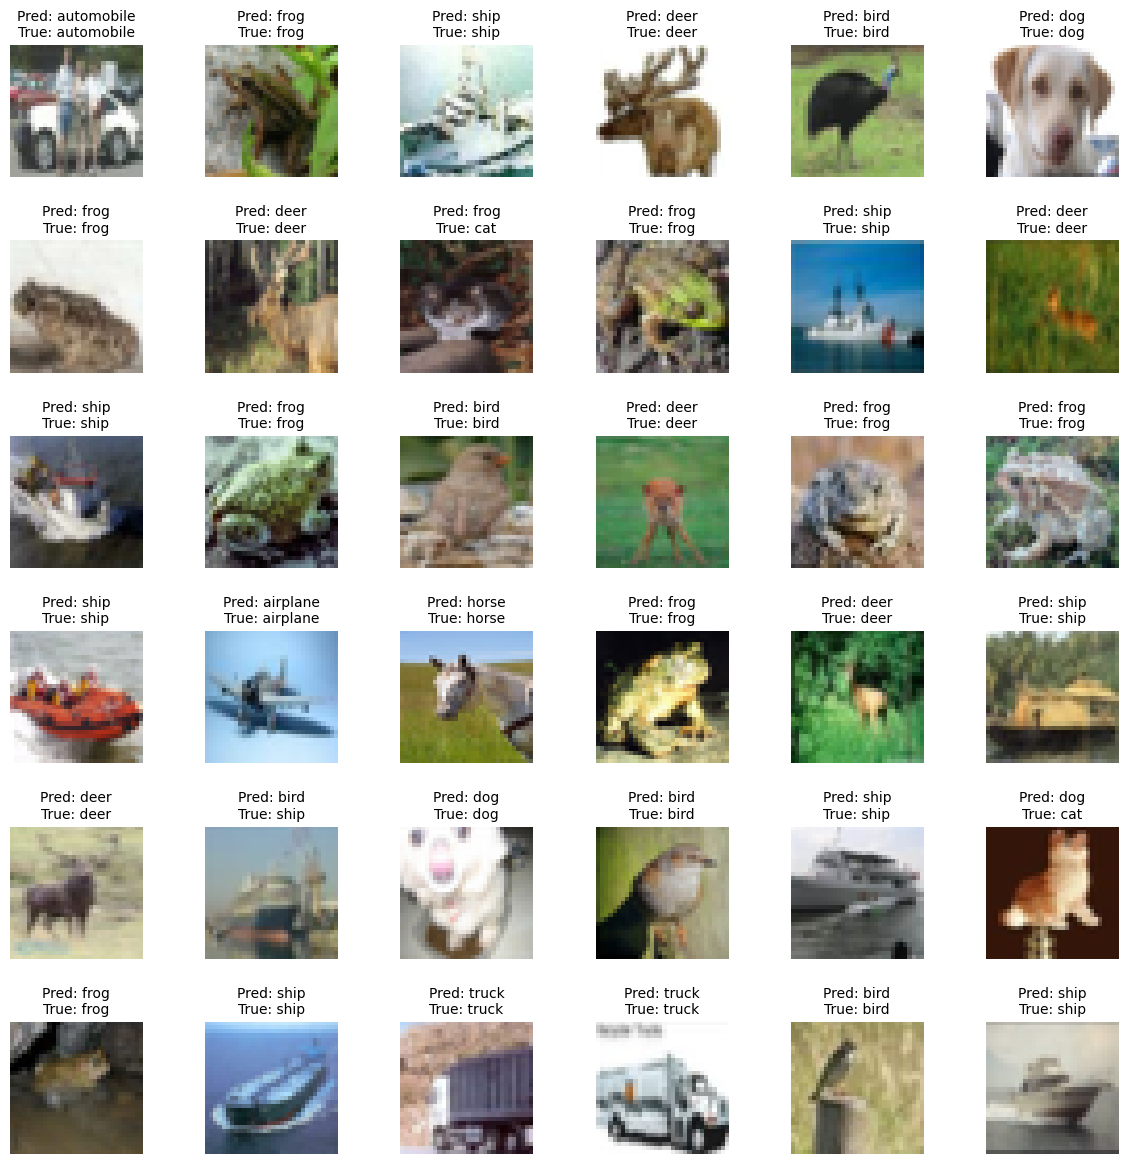

Epoch [8/10], Loss: 0.7031, Accuracy: 73.01%


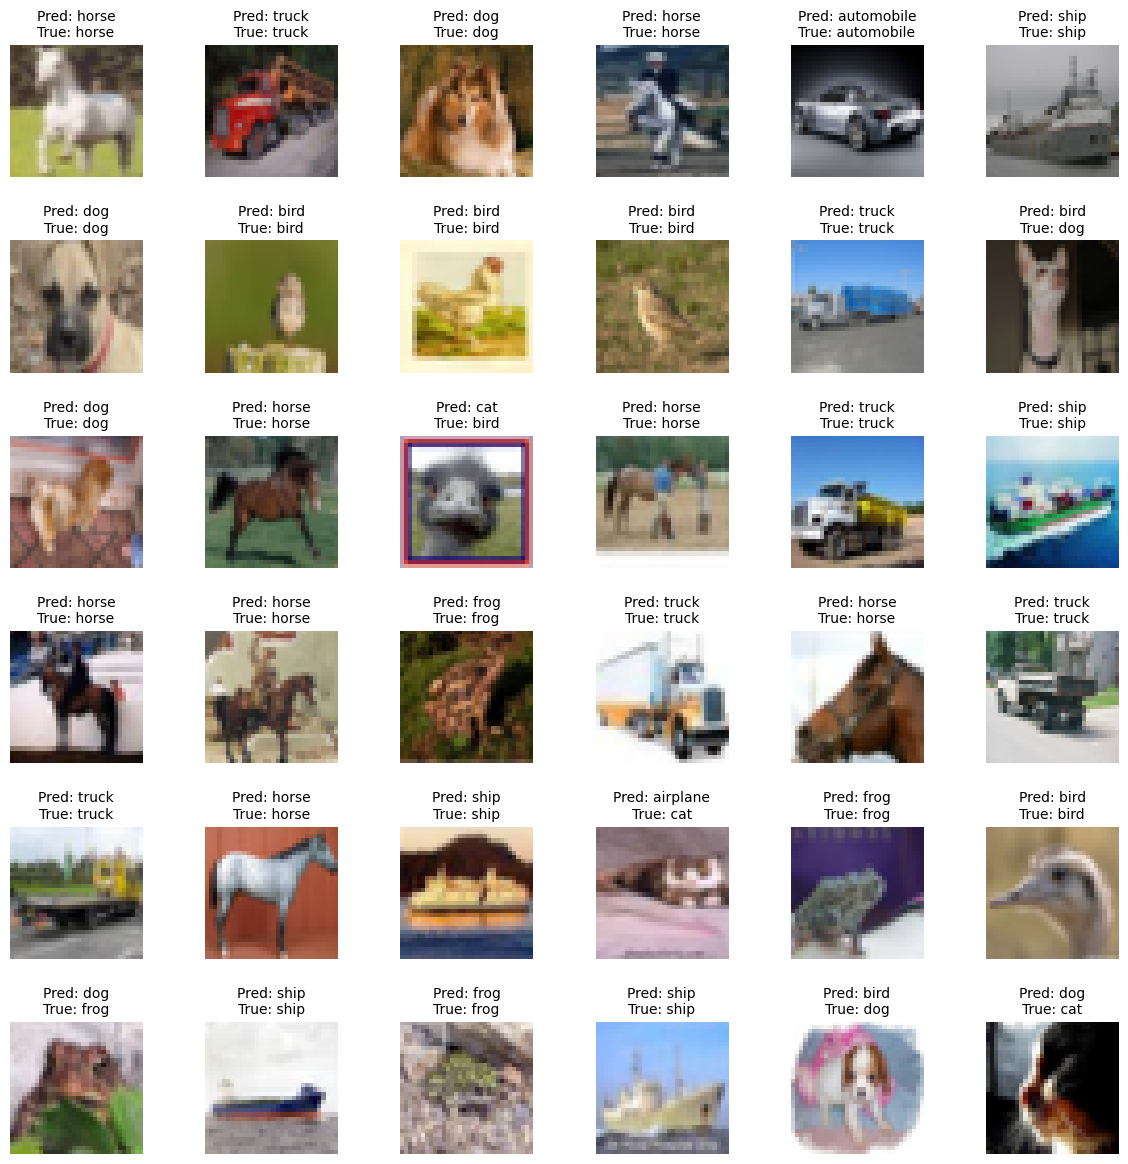

Epoch [9/10], Loss: 0.6697, Accuracy: 73.99%


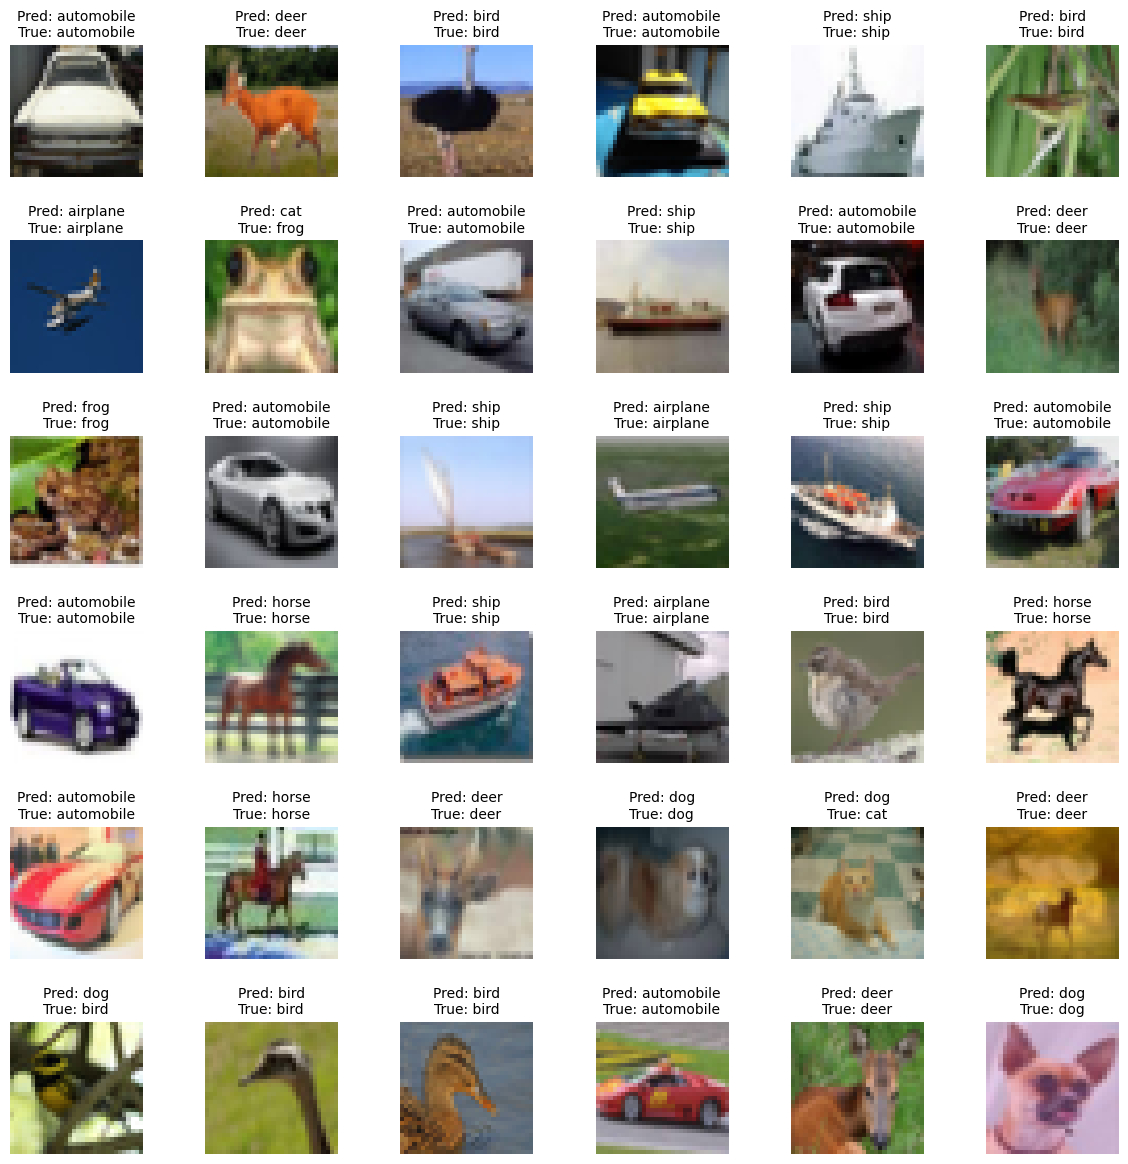

Epoch [10/10], Loss: 0.6428, Accuracy: 74.86%


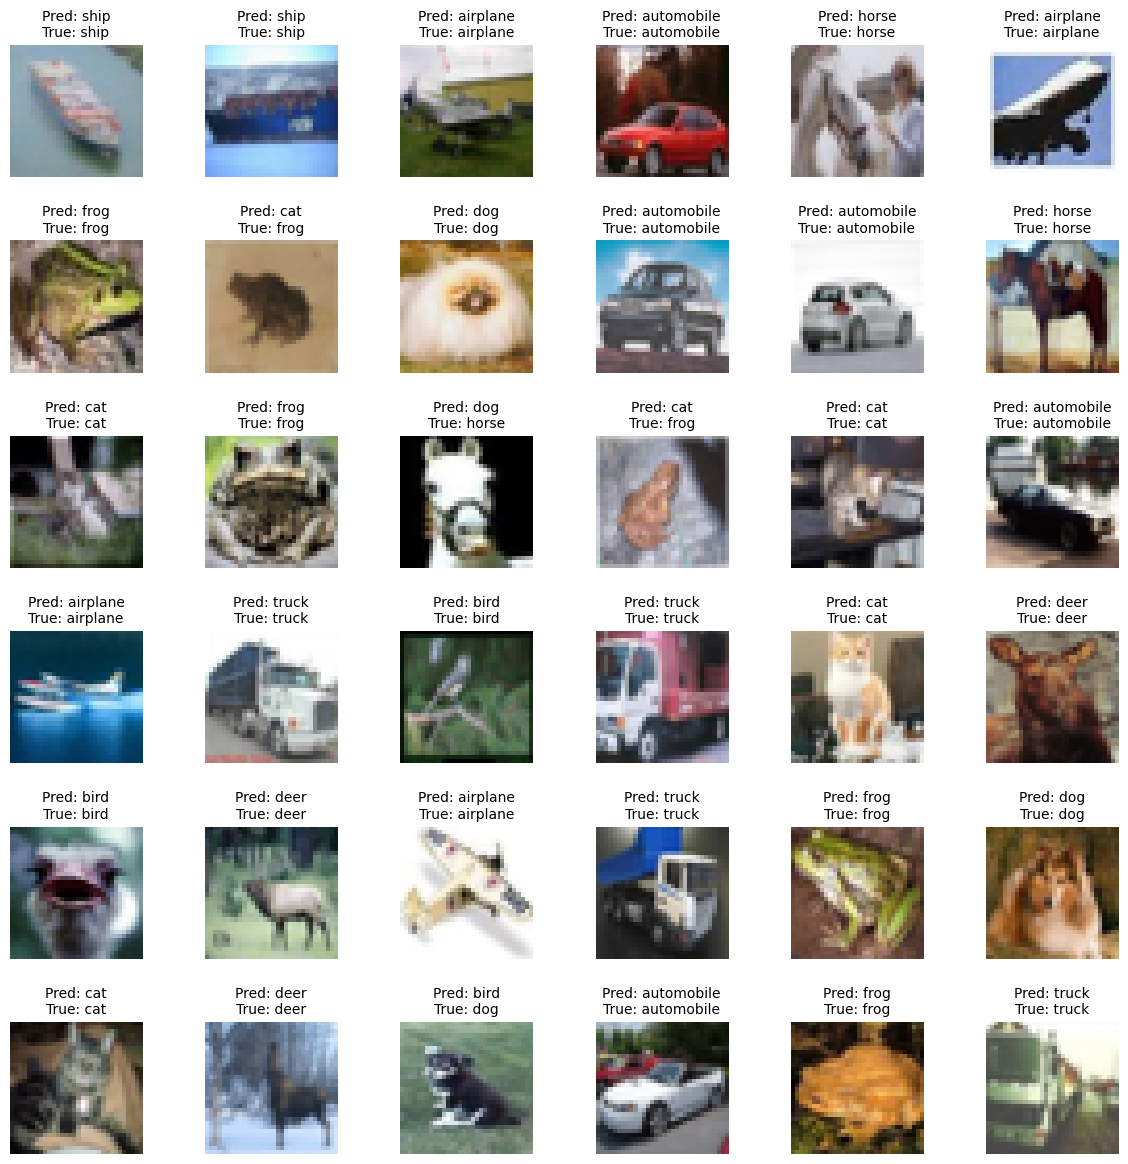

In [116]:
# Training Loop
num_epochs = 10
model_cifar.train()
for epoch in range(num_epochs):
    total_loss = 0
    for images, labels in train_loader_cifar10:
        optimizer.zero_grad()

        # Forward pass
        features = model_cifar(images)
        loss = arcface_cifar(features, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        # Calculate accuracy for the batch
        with torch.no_grad():
            logits = torch.matmul(fn.normalize(features), fn.normalize(arcface_cifar.weight).T) * arcface_cifar.scale
            predicted = torch.argmax(logits, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate accuracy for the epoch
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader_mnist):.4f}, Accuracy: {accuracy:.2f}%")
    # Visualize predictions on the training set after each epoch
    visualize_predictions_grid(model_cifar, train_loader_cifar10, arcface_cifar, num_images=36,class_names=cifar_class_names)

Test Accuracy on CIFAR-10: 72.51%


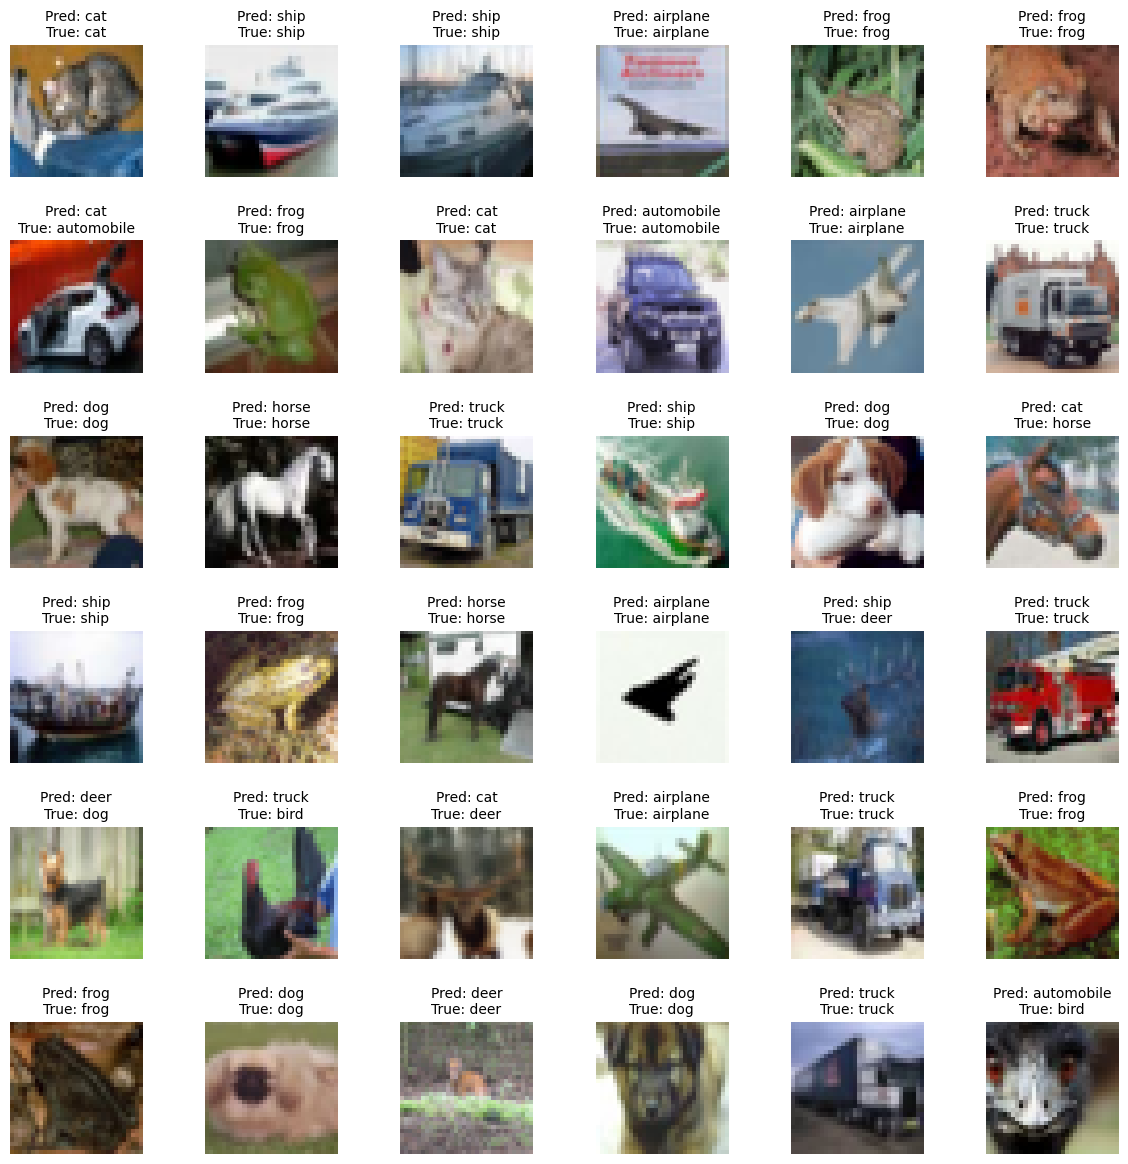

In [122]:
# Evaluation loop
model_cifar.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader_cifar10:
        features = model_cifar(images)
        logits = torch.matmul(fn.normalize(features),
                              fn.normalize(arcface_cifar.weight).T) * arcface_cifar.scale
        predicted = torch.argmax(logits, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy on CIFAR-10: {accuracy:.2f}%")

# Visualize predictions on the test set after evaluation
visualize_predictions_grid(model_cifar, test_loader_cifar10, arcface_cifar,num_images=36, class_names=cifar_class_names)